In [8]:
# Ensure the project root is in the Python path
import sys
sys.path.append('/Users/tl759k/Documents/GitHub/work/cursor-analytics')

# Activate the virtual environment (if not already activated)
# This is typically done outside the notebook, but we ensure the path is correct here
import os
os.system('source /Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/bin/activate')

# Re-import the SnowflakeHook after ensuring the path is set
from utils.snowflake_connection import SnowflakeHook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import plotly.graph_objects as go
import seaborn as sns
import statsmodels.formula.api as smf
from decimal import Decimal
import plotly.express as px
from IPython.display import display

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm


# Load the SQL query from the file
def load_query(file_path):
    with open(file_path, 'r') as file:
        query = file.read()
    snowhook = SnowflakeHook()
    df = snowhook.query_snowflake(query, method='pandas')

    # format decimal to float
    for col in df.columns:
        if df[col].dtype == 'object':
            # Check if column has any non-null values before checking type
            non_null_values = df[col].dropna()
            if len(non_null_values) > 0 and isinstance(non_null_values.iloc[0], Decimal):
                df[col] = df[col].astype(float)

    return df

## 0. Data Prep

Lifetime Applicants by MSA (State)

In [53]:
df_lifetime_apps = load_query('data/sql/lifetime_apps_by_cbsa.sql')
df_lifetime_apps.head()

2025-09-09 16:27:39,914 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-09-09 16:27:39,915 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


2025-09-09 16:27:40,243 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-09-09 16:27:40,243 - utils.snowflake_connection - INFO - Executing query (pandas)


,cbsa,msa,age18plus_tot,age1824_tot,apps_18_to_19,apps_18_to_24,apps_18plus,apps_18plus_share_of_population,apps_18to24_share_of_population
0,40140,"Riverside-San Bernardino-Ontario, CA",3603470.0,453521.0,680,28894,588732,0.163379,0.008018
1,24540,"Greeley, CO",277340.0,32715.0,879,12904,81426,0.293596,0.046528
2,22900,"Fort Smith, AR-OK",178097.0,19875.0,652,3796,27654,0.155275,0.021314
3,19180,"Danville, IL",54575.0,5572.0,188,1309,9168,0.167989,0.023985
4,15940,"Canton-Massillon, OH",315643.0,32255.0,1856,11559,61017,0.193310,0.036620


Active Dx who completed one delivery in 2024

In [101]:
df_active_dx_by_cbsa = load_query('./data/sql/active_dx_by_cbsa.sql')

2025-09-09 18:13:19,816 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-09-09 18:13:19,817 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


2025-09-09 18:13:20,202 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-09-09 18:13:20,203 - utils.snowflake_connection - INFO - Executing query (pandas)


### Market Penetration

In [54]:
def prepare_geo_map_data(df, metric):
    # Load CBSA polygons (MSA+µSA) from local file
    cbsa = gpd.read_file("./data/tl_2024_us_cbsa/tl_2024_us_cbsa.shp")
    cbsa['CBSAFP'] = cbsa['CBSAFP'].astype(str).str.zfill(5)

    # Keep only MSAs and mainland
    cbsa_ll = cbsa.to_crs(4326)
    rep_pts = cbsa_ll.geometry.representative_point()
    mainland_mask = rep_pts.x.between(-125, -66) & rep_pts.y.between(24, 50)
    cbsa_mainland = cbsa.loc[mainland_mask].copy()
    cbsa_mainland = cbsa_mainland.to_crs(5070)
    cbsa_mainland["geometry"] = cbsa_mainland.geometry.simplify(
        tolerance=1000, preserve_topology=True
    )

    merged = cbsa_mainland.merge(
        df[['cbsa', metric]],
        left_on="CBSAFP",
        right_on="cbsa",
        how="left"
    )

    # Fill missing values so map renders
    merged[metric] = merged[metric].fillna(0)
    epsilon = 1e-6
    merged[metric] = np.where(merged[metric] > 0, merged[metric], epsilon)

    return merged

In [55]:
def plot_geo_map_matplotlib(df, metric, title, figsize=(10, 5), legend_position="top_right", colormap="YlGnBu", colormap_start=0, colormap_end=1):
    """
    Create a choropleth map using matplotlib with ZERO whitespace,
    and a small horizontal colorbar inside the map.
    
    Parameters:
    df: GeoDataFrame with geometry and the metric column
    metric: string, name of the column to visualize  
    title: string, title for the colorbar
    figsize: tuple, figure size in inches (width, height)
    legend_position: 'bottom_left' or 'top_right'
    
    Returns:
    matplotlib figure with no whitespace
    """
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import numpy as np
    from matplotlib.colors import Normalize, ListedColormap
    import contextily as ctx

    # Create figure
    fig, ax = plt.subplots(figsize=figsize, facecolor="white")
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)

    # Remove axes
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")

    # Colormap
    base_cmap = cm.get_cmap(colormap)
    colors = [base_cmap(i) for i in np.linspace(colormap_start, colormap_end, 256)]
    dark_ylgnbu = ListedColormap(colors)

    # Normalize
    norm = Normalize(vmin=df[metric].min(), vmax=df[metric].max())

    # Plot data
    df.plot(
        column=metric,
        cmap=dark_ylgnbu,
        norm=norm,
        ax=ax,
        edgecolor="black",
        linewidth=0.2,
        missing_kwds={"color": "lightgray", "alpha": 0.5},
    )

    # Optional basemap
    try:
        df_web_mercator = df.to_crs(epsg=3857)
        ctx.add_basemap(ax, crs=df_web_mercator.crs, source=ctx.providers.CartoDB.Positron, alpha=0.5)
    except:
        pass

    ax.set_xlim(df.total_bounds[0], df.total_bounds[2])
    ax.set_ylim(df.total_bounds[1], df.total_bounds[3])

    # --- Add horizontal colorbar INSIDE map ---
    if legend_position == "bottom_left":
        cbar_ax = fig.add_axes([0.05, 0.05, 0.25, 0.025])  # bottom left
    elif legend_position == "top_right":
        cbar_ax = fig.add_axes([0.63, 0.98, 0.25, 0.015])  # top right
    else:
        raise ValueError("legend_position must be 'bottom_left' or 'top_right'")

    sm = plt.cm.ScalarMappable(cmap=dark_ylgnbu, norm=norm)
    sm.set_array([])
    # cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal", ticks=np.linspace(df[metric].min(), df[metric].max(), 5))
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
    import matplotlib.ticker as mticker
        # Use MaxNLocator for "nice" rounded ticks (in percent units)
    cbar.ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=6))  # up to 6 ticks

    # Format ticks as whole percentages (no decimals)
    cbar.ax.xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=0))

    # Style the colorbar
    # cbar.set_label(title, fontsize=7, labelpad=2)
    cbar.ax.tick_params(labelsize=6)
    cbar.outline.set_linewidth(0.5)
    cbar.ax.patch.set_facecolor("white")
    cbar.ax.patch.set_alpha(0.8)

    plt.margins(0, 0)

    # return fig


#### 1. Lifetime Apps (%) of 18 Plus Population

/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_54927/3871617953.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = cm.get_cmap(colormap)


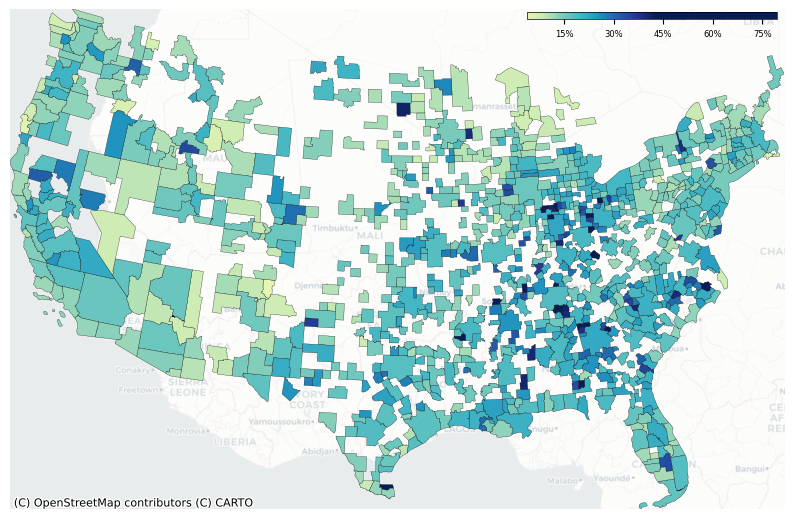

In [75]:
merged = prepare_geo_map_data(df_lifetime_apps, 'apps_18plus_share_of_population')

plot_geo_map_matplotlib(merged
    , 'apps_18plus_share_of_population'
    , 'Apps 18+ Share of Population'
    , figsize=(10, 5)
    , legend_position="top_right"
    , colormap="YlGnBu"
    , colormap_start=0.15
    , colormap_end=1.8
    )

#### 2. Lifetime Apps (%) of Population - Age 18-24

/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_54927/3871617953.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = cm.get_cmap(colormap)


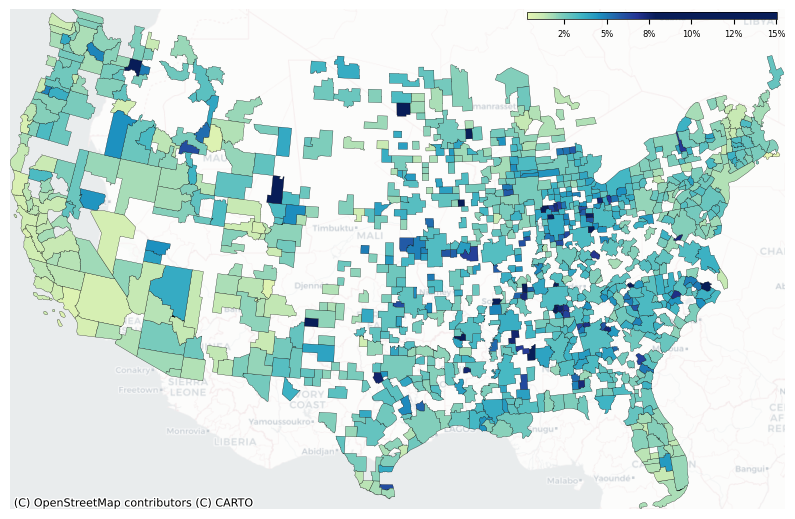

In [76]:
merged = prepare_geo_map_data(df_lifetime_apps, 'apps_18to24_share_of_population')

plot_geo_map_matplotlib(merged
    , 'apps_18to24_share_of_population'
    , 'Apps 18+ Share of Population'
    , figsize=(10, 5)
    , legend_position="top_right"
    , colormap="YlGnBu"
    , colormap_start=0.15
    , colormap_end=1.8
    )

#### 3. Active Dx Last year (2024)

In [102]:
df_active_dx_by_cbsa[df_active_dx_by_cbsa['age18plus_tot'].isna()]

,cbsa,active_dx_18_to_19,active_dx_18_to_24,active_dx_18plus,age18plus_tot,active_dx_18plus_share_of_population,active_dx_18to24_share_of_population
19,38660,24,227,877,NaN,NaN,NaN
93,10380,8,84,253,NaN,NaN,NaN
143,41980,278,3132,14583,NaN,NaN,NaN
160,32420,18,136,382,NaN,NaN,NaN
614,None,8221,123739,529236,NaN,NaN,NaN
715,99999,11866,83231,276986,NaN,NaN,NaN


In [103]:
df_active_dx_by_cbsa[~df_active_dx_by_cbsa['age18plus_tot'].isna()].sort_values(by='active_dx_18plus_share_of_population', ascending=False).head(100)

,cbsa,active_dx_18_to_19,active_dx_18_to_24,active_dx_18plus,age18plus_tot,active_dx_18plus_share_of_population,active_dx_18to24_share_of_population
418,30280,324,1555,5383,29011.0,0.185550,0.053600
170,23190,40,665,2833,15619.0,0.181382,0.042576
191,33900,169,1607,3446,19162.0,0.179835,0.083864
280,37500,217,1484,4635,35951.0,0.128925,0.041278
688,23140,147,930,2780,24364.0,0.114103,0.038171
...,...,...,...,...,...,...,...
24,28020,366,2829,9441,209676.0,0.045027,0.013492
33,21460,78,503,1921,42780.0,0.044904,0.011758
823,36180,39,416,2028,45190.0,0.044877,0.009206
98,22100,140,675,2405,53685.0,0.044798,0.012573


/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_54927/3871617953.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = cm.get_cmap(colormap)


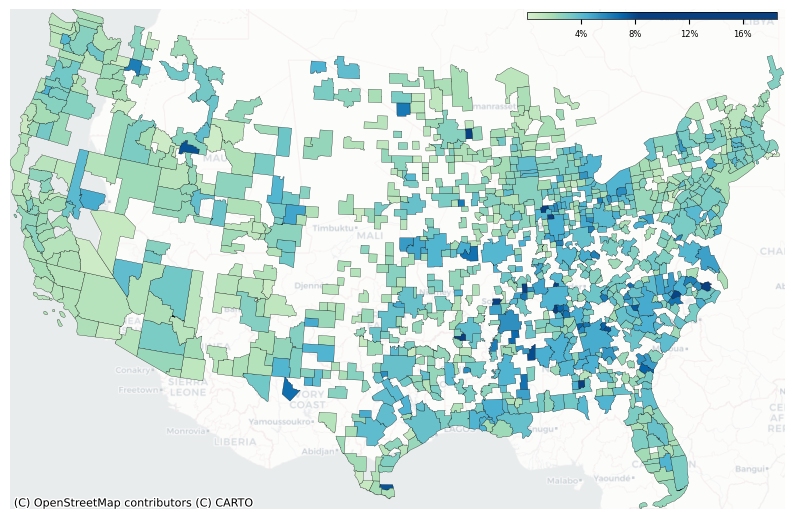

In [104]:
merged = prepare_geo_map_data(df_active_dx_by_cbsa, 'active_dx_18plus_share_of_population')

plot_geo_map_matplotlib(merged
    , 'active_dx_18plus_share_of_population'
    , 'Apps 18+ Share of Population'
    , figsize=(10, 5)
    , legend_position="top_right"
    , colormap="GnBu"
    , colormap_start=0.2
    , colormap_end=2
    )